In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1
!pip install git+https://github.com/qubvel/segmentation_models

     |████████████████████████████████| 421.8MB 22kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 450kB 50.6MB/s 
     |████████████████████████████████| 3.9MB 47.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=7df9ddd2617a69915e87ee5572225028ca5b4bb911ee9572bb0590f2f39b82e5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [3]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import cv2
import os
import math

In [4]:
path = '/content/drive/My Drive/btp'

In [ ]:
(audio, fs) = librosa.load(f'{path}/songs_polaND/Sittaeuropaea/Sittaeuropaea463674.wav')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
Audio(audio, rate = fs)

In [ ]:
def mean_sq(audio):
  sum_ =  0
  for i in range(len(audio)):
    sum_ = sum_ + audio[i]*audio[i]
  sum_ = sum_ / len(audio)
  return sum_

In [ ]:
def remove_silence(audio, threshold = 0.0002):
  del_index = []
  pp = audio.copy()
  for i in range(len(audio)):
    if(pp[i]**2 < threshold):
      #pp[i] = 0.0000001 #to avoid divide by zero error
      del_index.append(i)
  pp = np.delete(pp, del_index)
  return pp

In [ ]:
sil_rem = remove_silence(audio)

In [ ]:
Audio(sil_rem, rate=fs)

In [ ]:
genres = os.listdir(f'{path}/songs_polaND/')

In [ ]:
for g in genres[10:]:
  print(g)
  for filename in os.listdir(f'{path}/songs_polaND/{g}/'):
    #load audio
    (audio, fs) = librosa.load(f'{path}/songs_polaND/{g}/{filename}')
    #remove silence
    audio = remove_silence(audio)
    #split in clips of 5sec
    clips = np.array([audio[5*i*fs: 5*(i+1)*fs] for i in range(int(len(audio) / (5 * fs)))])
    for i in range(clips.shape[0]):
      S = librosa.feature.melspectrogram(clips[0], sr=fs, fmax = 8000)
      librosa.display.specshow(librosa.power_to_db(S,ref=np.max), fmax=8000)
      plt.savefig(os.path.join(f'{path}/poland_mel_spectograms_01/{g}/{filename}_{i}.jpg'))  
    
    

In [5]:
import sys
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import efficientnet.tfkeras as efn #Convolutional Neural Network architecture
from efficientnet.keras import center_crop_and_resize, preprocess_input
from sklearn.utils import class_weight

Using TensorFlow backend.


In [ ]:
BIRDS = []
for bird in os.listdir(f'{path}/poland_mel_spectograms_01/data/train/'):
  BIRDS.append(bird)


In [ ]:
BIRDS

['Alaudaarvensis',
 'Chlorischloris',
 'Emberizacitrinella',
 'Erithacusrubecula',
 'Fringillacoelebs']

In [ ]:
IM_SIZE = (224, 224)
BATCH_SIZE = 16
DATA_PATH = f'{path}/poland_mel_spectograms_01/data/'

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   fill_mode='nearest')  
train_batches = train_datagen.flow_from_directory(DATA_PATH+'train',
                                                  classes=BIRDS,
                                                  target_size=IM_SIZE,
                                                  class_mode='categorical', shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)
valid_batches = valid_datagen.flow_from_directory(DATA_PATH+'val',
                                                  classes=BIRDS,
                                                  target_size=IM_SIZE,
                                                  class_mode='categorical', shuffle=False,
                                                  batch_size=BATCH_SIZE)


Found 950 images belonging to 5 classes.
Found 458 images belonging to 5 classes.


In [ ]:
#Define CNN's architecture
net = efn.EfficientNetB3(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(224, 224, 3))  
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(BIRDS), activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)     
net_final.compile(optimizer=Adam(),
                  loss='categorical_crossentropy', metrics=['accuracy'])

#print(net_final.summary())

In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_batches.classes), 
                train_batches.classes)

# Define callbacks
ModelCheck = ModelCheckpoint(f'{path}/efficientnet_checkpoint.h5', monitor='val_loss', verbose=0, 
                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=3e-4)

In [ ]:
#train
net_final.fit_generator(train_batches,
                        validation_data = valid_batches,
                        epochs = 30,
                        steps_per_epoch= 60,
                        class_weight=class_weights, callbacks=[ModelCheck,ReduceLR])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 60 steps, validate for 29 steps
Epoch 1/30
60/60 [==============================] - 35s 590ms/step - loss: 1.6807 - accuracy: 0.6874 - val_loss: 1.7080 - val_accuracy: 0.8100
Epoch 2/30
60/60 [==============================] - 22s 360ms/step - loss: 1.1298 - accuracy: 0.8137 - val_loss: 2.9542 - val_accuracy: 0.8144
Epoch 3/30
60/60 [==============================] - 21s 358ms/step - loss: 1.7664 - accuracy: 0.7874 - val_loss: 6.5277 - val_accuracy: 0.7838
Epoch 4/30
60/60 [==============================] - 23s 382ms/step - loss: 1.0611 - accuracy: 0.8537 - val_loss: 1.3648 - val_accuracy: 0.8624
Epoch 5/30
60/60 [==============================] - 22s 363ms/step - loss: 0.5914 - accuracy: 0.9074 - val_loss: 1.5373 - val_accuracy: 0.8930
Epoch 6/30
60/60 [==============================] - 22s 359ms/step - loss: 1.0718 - accuracy: 0.8874 - val_loss: 1.6909 - val_accuracy: 0.8952
Epoch 7/30
60/60 [==============================] 

Parameters:  
Batch Size  
Optimizer  
Dropout  
EfficientNet version  
Loss Function  
Patience (ReduceLR)   
Factor (ReduceLR)  
epochs

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   fill_mode='nearest')  

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)



In [ ]:
def wrapper_fun(i, batch_size, optimizer, factorLR, patienceLR, epoch_count):
  IM_SIZE = (224, 224)
  BATCH_SIZE = batch_size
  DATA_PATH = f'{path}/poland_mel_spectograms_01/data/'

  
  train_batches = train_datagen.flow_from_directory(DATA_PATH+'train',
                                                    classes=BIRDS,
                                                    target_size=IM_SIZE,
                                                    class_mode='categorical', shuffle=True,
                                                    batch_size=BATCH_SIZE)

  
  valid_batches = valid_datagen.flow_from_directory(DATA_PATH+'val',
                                                    classes=BIRDS,
                                                    target_size=IM_SIZE,
                                                    class_mode='categorical', shuffle=False,
                                                    batch_size=BATCH_SIZE)
  #Define CNN's architecture
  net = efn.EfficientNetB3(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(224, 224, 3))  
  x = net.output
  x = Flatten()(x)
  x = Dropout(0.5)(x)
  output_layer = Dense(len(BIRDS), activation='softmax', name='softmax')(x)
  net_final = Model(inputs=net.input, outputs=output_layer) 
  net_final.compile(optimizer=optimizer,
                    loss='categorical_crossentropy', metrics=['accuracy'])
  
  class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_batches.classes), 
                train_batches.classes)

  # Define callbacks
  ModelCheck = ModelCheckpoint(f'{path}/taguchi_models/efficientnet_checkpoint_{i}.h5', monitor='val_loss', verbose=0, 
                              save_best_only=True, save_weights_only=True, mode='auto', period=1)

  ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=factorLR,
                                patience=patienceLR, min_lr=3e-4)
  
  #train
  net_final.fit_generator(train_batches,
                          validation_data = valid_batches,
                          epochs = epoch_count,
                          steps_per_epoch= math.ceil(950 / BATCH_SIZE),
                          class_weight=class_weights, callbacks=[ModelCheck,ReduceLR])

In [ ]:
# 5 parameters, 4 levels -> L16 orthogonal array
batch_size = [4, 16, 64, 32]
optimizers = [Adam(), SGD(), Adagrad(), Adadelta()]
factor = [0.2, 0.4, 0.8, 0.8]
patience = [3, 4, 5, 6]
epochs = [10, 20, 30, 40]
orth_array = [[1, 1, 1, 1, 1], 
              [1, 2, 2, 2, 2], 
              [1, 3, 3, 3, 3], 
              [1, 4, 4, 4, 4], 
              [2, 1, 2, 3, 4], 
              [2, 2, 1, 4, 3], 
              [2, 3, 4, 1, 2], 
              [2, 4, 3, 2, 1], 
              [3, 1, 3, 4, 2], 
              [3, 2, 4, 3, 1], 
              [3, 3, 1, 2, 4], 
              [3, 4, 2, 1, 3], 
              [4, 1, 4, 2, 3], 
              [4, 2, 3, 1, 4], 
              [4, 3, 2, 4, 1], 
              [4, 4, 1, 3, 2]]



In [ ]:
for i in range(len(orth_array)):
  wrapper_fun(i + 1, batch_size[orth_array[i][0] - 1], optimizers[orth_array[i][1] - 1], factor[orth_array[i][2] - 1], patience[orth_array[i][3] - 1], epochs[orth_array[i][4] - 1])

Found 950 images belonging to 5 classes.
Found 458 images belonging to 5 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 238 steps, validate for 115 steps
Epoch 1/10
238/238 [==============================] - 46s 194ms/step - loss: 4.7657 - accuracy: 0.5821 - val_loss: 139.8304 - val_accuracy: 0.0961
Epoch 2/10
238/238 [==============================] - 27s 114ms/step - loss: 5.4274 - accuracy: 0.5758 - val_loss: 2913.9522 - val_accuracy: 0.3384
Epoch 3/10
238/238 [==============================] - 28s 119ms/step - loss: 6.1497 - accuracy: 0.5737 - val_loss: 2.2993 - val_accuracy: 0.6790
Epoch 4/10
238/238 [==============================] - 28s 117ms/step - loss: 4.8997 - accuracy: 0.5947 - val_loss: 19.6151 - val_accuracy: 0.5415
Epoch 5/10
238/238 [==============================] - 28s 117ms/step - loss: 4.1720 - accuracy: 0.6147 - val_loss: 4.5362 - val_accuracy: 0.6812
Epoch 6/10
238/23

/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


ResourceExhaustedError: ignored

In [ ]:
for i in range(8,len(orth_array)):
  wrapper_fun(i + 1, batch_size[orth_array[i][0] - 1], optimizers[orth_array[i][1] - 1], factor[orth_array[i][2] - 1], patience[orth_array[i][3] - 1], epochs[orth_array[i][4] - 1])

Found 950 images belonging to 5 classes.
Found 458 images belonging to 5 classes.
44113920/44107200 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 8 steps
Epoch 1/20
15/15 [==============================] - 344s 23s/step - loss: 1.1725 - accuracy: 0.6937 - val_loss: 1.3332 - val_accuracy: 0.7424
Epoch 2/20
15/15 [==============================] - 21s 1s/step - loss: 0.3944 - accuracy: 0.8779 - val_loss: 2.4082 - val_accuracy: 0.8515
Epoch 3/20
15/15 [==============================] - 21s 1s/step - loss: 0.3400 - accuracy: 0.9326 - val_loss: 3.0757 - val_accuracy: 0.6659
Epoch 4/20
15/15 [==============================] - 21s 1s/step - loss: 0.3876 - accuracy: 0.9232 - val_loss: 13.0037 - val_accuracy: 0.4083
Epoch 5/20
15/15 [==============================] - 21s 1s/step - loss: 0.1662 - accuracy: 0.9558 - val_loss: 4.7425 - val_

/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


ResourceExhaustedError: ignored

In [ ]:
for i in range(12,len(orth_array)):
  wrapper_fun(i + 1, batch_size[orth_array[i][0] - 1], optimizers[orth_array[i][1] - 1], factor[orth_array[i][2] - 1], patience[orth_array[i][3] - 1], epochs[orth_array[i][4] - 1])

Found 950 images belonging to 5 classes.
Found 458 images belonging to 5 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 15 steps
Epoch 1/30
30/30 [==============================] - 39s 1s/step - loss: 1.0823 - accuracy: 0.7463 - val_loss: 1.8344 - val_accuracy: 0.8253
Epoch 2/30
30/30 [==============================] - 21s 704ms/step - loss: 0.4434 - accuracy: 0.8989 - val_loss: 20.6717 - val_accuracy: 0.6638
Epoch 3/30
30/30 [==============================] - 22s 735ms/step - loss: 0.4270 - accuracy: 0.9074 - val_loss: 1.1945 - val_accuracy: 0.8319
Epoch 4/30
30/30 [==============================] - 21s 700ms/step - loss: 0.2378 - accuracy: 0.9537 - val_loss: 1.6687 - val_accuracy: 0.9083
Epoch 5/30
30/30 [==============================] - 21s 700ms/step - loss: 0.2891 - accuracy: 0.9453 - val_loss: 4.7981 - val_accuracy: 0.8908
Epoch 6/30
30/30 [==============================] - 21s 694ms/step - loss: 0.4705 - accuracy: 0.9305 - val_loss: 

In [ ]:
for i in range(13,len(orth_array)):
  wrapper_fun(i + 1, batch_size[orth_array[i][0] - 1], optimizers[orth_array[i][1] - 1], factor[orth_array[i][2] - 1], patience[orth_array[i][3] - 1], epochs[orth_array[i][4] - 1])

Found 950 images belonging to 5 classes.
Found 458 images belonging to 5 classes.
44113920/44107200 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 15 steps
Epoch 1/40
30/30 [==============================] - 235s 8s/step - loss: 1.5873 - accuracy: 0.6695 - val_loss: 1.2157 - val_accuracy: 0.8210
Epoch 2/40
30/30 [==============================] - 21s 704ms/step - loss: 0.5374 - accuracy: 0.8432 - val_loss: 1.3742 - val_accuracy: 0.6703
Epoch 3/40
30/30 [==============================] - 22s 744ms/step - loss: 0.2730 - accuracy: 0.9168 - val_loss: 0.8628 - val_accuracy: 0.8537
Epoch 4/40
30/30 [==============================] - 23s 750ms/step - loss: 0.2331 - accuracy: 0.9358 - val_loss: 0.5335 - val_accuracy: 0.8996
Epoch 5/40
30/30 [==============================] - 23s 751ms/step - loss: 0.2109 - accuracy: 0.9453 - val_loss: 0.

In [ ]:
results = [85.15, 98.47, 99.56, 73.36, 99.34, 99.34, 99.13, 60.48, 98.47, 89.52, 99.13, 72.49, 99.56, 99.13, 96.51, 67.03]
sni = [-10 * math.log10(1/(results[i] ** 2)) for i in range(16)]
sni_features = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0 ,0 ,0, 0]]
for i in range(16):
  for j in range(5):
    sni_features[orth_array[i][j] - 1][j] = sni_features[orth_array[i][j] - 1][j] + sni[i]
for i in range(4):
  for j in range(5):
    sni_features[i][j] = sni_features[i][j] / 4

In [ ]:
diff = [0, 0, 0, 0, 0]
ix = [0, 0, 0, 0, 0]
for j in range(5):
  l = [sni_features[i][j] for i in range(4)]
  diff[j] = max(l) - min(l)
  ix[j] = l.index(max(l)) + 1

In [ ]:
diff

[0.1653316457017766,
 3.2072449580687987,
 0.4274768771133566,
 0.3562700866738595,
 1.0335243337205995]

In [ ]:
ix

[4, 3, 2, 4, 4]

Hence, the optimized parameters are:  
Batch Size = 32  
Optimizer = Adagrad  
FactorLR = 0.4  
PatienceLR = 6  
Epochs = 40  
  
Optimizer affects the performance the most (3.2), followed by  
Epochs (1.03)  
factorRL(0.42)  
PatienceRL(0.35)  
and Batch Size (0.16) which affects the performance of model the least.

In [ ]:
#running the tuned model
wrapper_fun(17, 31, Adagrad(), 0.4, 6, 40)

Found 950 images belonging to 5 classes.
Found 458 images belonging to 5 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 15 steps
Epoch 1/40
31/31 [==============================] - 39s 1s/step - loss: 1.1911 - accuracy: 0.5979 - val_loss: 1.4446 - val_accuracy: 0.4913
Epoch 2/40
31/31 [==============================] - 22s 722ms/step - loss: 0.6133 - accuracy: 0.7884 - val_loss: 1.3844 - val_accuracy: 0.6594
Epoch 3/40
31/31 [==============================] - 23s 728ms/step - loss: 0.4801 - accuracy: 0.8347 - val_loss: 1.0460 - val_accuracy: 0.6834
Epoch 4/40
31/31 [==============================] - 23s 729ms/step - loss: 0.4169 - accuracy: 0.8589 - val_loss: 0.6999 - val_accuracy: 0.8559
Epoch 5/40
31/31 [==============================] - 22s 724ms/step - loss: 0.3370 - accuracy: 0.8842 - val_loss: 0.4113 - val_accuracy: 0.8755
Epoch 6/40
31/31 [==============================] - 23s 734ms/step - loss: 0.2438 - accuracy: 0.9116 - val_loss: 0

In [ ]:
results

[85.15,
 98.47,
 99.56,
 73.36,
 99.34,
 99.34,
 99.13,
 60.48,
 98.47,
 89.52,
 99.13,
 72.49,
 99.56,
 99.13,
 96.51,
 67.03]

In [ ]:
sni

[38.6036930459724,
 39.86607875838949,
 39.96169775873111,
 37.30918645323929,
 39.94248311318409,
 39.94248311318409,
 39.924102123566485,
 35.632235649863006,
 39.86607875838949,
 39.03840147040587,
 39.924102123566485,
 37.2055619950447,
 39.96169775873111,
 39.924102123566485,
 39.691446312432646,
 36.525384387874524]

In [ ]:
sni_features

[[38.93516400408308,
  39.593488169069275,
  38.74891566764937,
  38.91436482203751,
  38.241444119668486],
 [38.86032599994942,
  39.69276636638648,
  39.17639254476273,
  38.84602857263752,
  39.045411007054994],
 [39.008536086851635,
  39.87533707957418,
  38.84602857263752,
  38.8669916825489,
  39.26786015642275],
 [39.025657645651194,
  36.66809212150538,
  39.05834695148569,
  39.20229865931138,
  39.274968453389086]]

TRIAL SNIPPETS (IGNORE)

from turduspilaris to fringillacoelebs -> images have been stored; except for Emberizacitrinella (2 songs done out of 50) and Fringillacoelebs(92 songs out of 115 done)

In [ ]:
l = [1, 2, 3, 4]
l.index(min(l))

0

In [ ]:
genres

['Turduspilaris',
 'Alaudaarvensis',
 'Apusapus',
 'Cardueliscarduelis',
 'Chlorischloris',
 'Coccothraustescoccothraustes',
 'Columbapalumbus',
 'Corvusfrugilegus',
 'Delichonurbicum',
 'Emberizacitrinella',
 'Erithacusrubecula',
 'Fringillacoelebs',
 'Garrulusglandarius',
 'Luscinialuscinia',
 'Motacillaalba',
 'Passerdomesticus',
 'Passermontanus',
 'Phoenicurusochruros',
 'Phoenicurusphoenicurus',
 'Phylloscopuscollybita',
 'Phylloscopustrochilus',
 'Picapica',
 'Sittaeuropaea',
 'Streptopeliadecaocto',
 'Sturnusvulgaris',
 'Troglodytestroglodytes',
 'Turdusmerula',
 'Turdusphilomelos']

In [ ]:
genres[10:]

['Erithacusrubecula',
 'Fringillacoelebs',
 'Garrulusglandarius',
 'Luscinialuscinia',
 'Motacillaalba',
 'Passerdomesticus',
 'Passermontanus',
 'Phoenicurusochruros',
 'Phoenicurusphoenicurus',
 'Phylloscopuscollybita',
 'Phylloscopustrochilus',
 'Picapica',
 'Sittaeuropaea',
 'Streptopeliadecaocto',
 'Sturnusvulgaris',
 'Troglodytestroglodytes',
 'Turdusmerula',
 'Turdusphilomelos']

In [ ]:
clips = np.array([sil_rem[5*i*fs: 5*(i+1)*fs] for i in range(int(len(sil_rem) / (5 * fs)))])

In [ ]:
mean_sq(pp[24*fs : 29*fs])

0.008018751995727765

In [ ]:
mean_sq(pp[12*fs : 18*fs])

2.0430930767358322e-08

In [ ]:
mean_sq(audio[12*fs : 18*fs])

7.273569347171609e-06

In [ ]:
mean_sq(audio[24*fs : 29*fs])

0.008030714077557134

In [ ]:
clips.shape

(2, 110250)

In [ ]:
del_index = []
for i in range(clips.shape[0]):
  if(mean_sq(clips[i]) <= 0.001):
    del_index.append(i)
clips = np.delete(clips, del_index, 0)

In [ ]:
clips.shape

(10, 110250)

In [ ]:
mean_sq(audio[15*fs : 20*fs])

1.6095094544429656e-05

In [ ]:
Audio(clips.flatten(), rate=fs)

In [ ]:
for folder in os.listdir(f'{path}/songs_polaND/'):
  os.mkdir(f'{path}/poland_mel_spectograms_01/{folder}/')

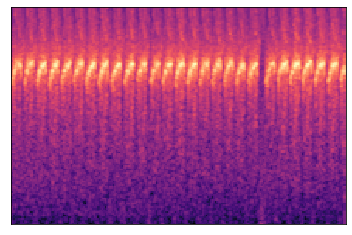

In [ ]:
s = librosa.feature.melspectrogram(clips[0], sr=fs, fmax = 8000)
librosa.display.specshow(librosa.power_to_db(s,ref=np.max), fmax=8000)
plt.savefig(os.path.join(f'{path}/try.jpg'))

In [ ]:
import cv2

In [ ]:
img = cv2.imread(f'{path}/try.jpg')

In [ ]:
img.shape

(288, 432, 3)

In [ ]:
clips.shape[0]

2

In [ ]:
Audio(audio, rate = fs)

In [ ]:
(mean_sq(audio)) ** 0.5

NameError: ignored

In [ ]:
for _ in os.listdir(f'{path}/poland_mel_spectograms_01/data/train/'):
  print(_+' '+str(len(os.listdir(f'{path}/poland_mel_spectograms_01/data/train/{_}'))))

Alaudaarvensis 77
Chlorischloris 68
Emberizacitrinella 228
Erithacusrubecula 299
Fringillacoelebs 278


In [ ]:
for _ in os.listdir(f'{path}/poland_mel_spectograms_01/data/val/'):
  print(_+' '+str(len(os.listdir(f'{path}/poland_mel_spectograms_01/data/val/{_}'))))

Alaudaarvensis 39
Chlorischloris 36
Emberizacitrinella 114
Erithacusrubecula 150
Fringillacoelebs 119


In [ ]:
typ = 'Alaudaarvensis'
files = os.listdir(f'{path}/poland_mel_spectograms_01/data/train/{typ}')
for i in range(0, len(files), 3):
  os.rename(f'{path}/poland_mel_spectograms_01/data/train/{typ}/{files[i]}', f'{path}/poland_mel_spectograms_01/data/val/{typ}/{files[i]}')

In [ ]:
temp = []
temp = [0 for i in range(0, 103, 3)]
len(temp)

35

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ewy12qca
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ewy12qca
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=e0bd2e5e330560053d78fdf534186134f1b9d84b9c784b89e84a2166a38e8250
  Stored in directory: /tmp/pip-ephem-wheel-cache-cfmowuer/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
math.ceil(950/16)

60

In [15]:
pip freeze --local > /content/drive/My\ Drive/btp/requirements.txt

In [14]:
path

'/content/drive/My Drive/btp'